### makemore: part 3

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length : how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% training set
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev=validation set
Xte, Yte = build_dataset(words[n2:])      # 10% test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [59]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

seed_num = 2147483647
g = torch.Generator().manual_seed(seed_num)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # we want roughly zero at logits
b2 = torch.randn(vocab_size,generator=g) * 0 # at initialization, bias starts with 0, because we want roughly zero at logits.

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


### problem 1 : at initialization

In [ ]:
# at initialization, uniform distribution , (a-z) alphabet.
-torch.tensor(1/27.0).log()

# but at the start, loss starts with 
# '0/ 200000: 27.8817'
# it means at starting, the neural net is creating probability distributions that are all messed up, some character is confident, and some character is not.

# so basically what's happening right is that the network is very confidently wrong.

# 4-dimensional example of the issue
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss =  -probs[2].log()
probs, loss

'''
# 27-dimensional example of the issue
logits = torch.zeros(27).float()
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss
'''

### problem 2 : vector 'h', gradient vanishing

In [60]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break 

      0/ 200000: 3.3221


In [70]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

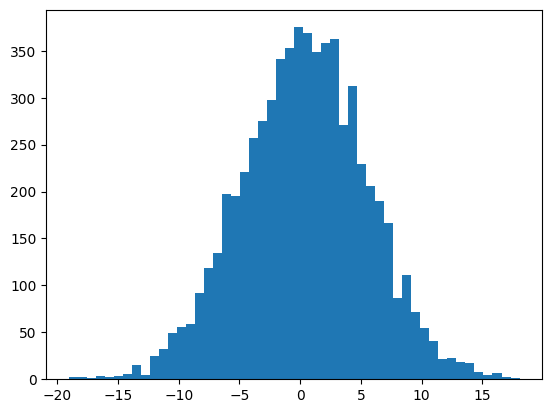

In [71]:
plt.hist(hpreact.view(-1).tolist(), bins = 50)


tanh 함수를 통과하면서 각각 1.0 또는 -1.0에 매우 가까운 값으로 바뀌는데, 넓은 범위의 입력값들이 모두 이 좁은 출력 범위로 '압축(squashed)되고 있다.  

이는 기울기가 소실되어버리는 현상으로 이어지는데, tanh의 그래프 개형이 1, -1에 가까워질수록 기울기가 점차 0에 가까워지기 때문이다.
기울기가 0에 가까워진다는 말은 변화율이 0에 수렴한다는 뜻이고, 
변화율이 0에 수렴한다는 것은 거의 안 변한다, 변화율이 미미하다는 뜻이다.   

즉, 이는 넓은 범위의 입력값들이 좁은 출력 범위로 압축되어 1, -1로 몰리면서, 엄청난 차이를 가진 값들이, 상대적으로 매우 미미한 차이로 좁혀지는 squashed 된다는 점에서 일맥상통하다.  

(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

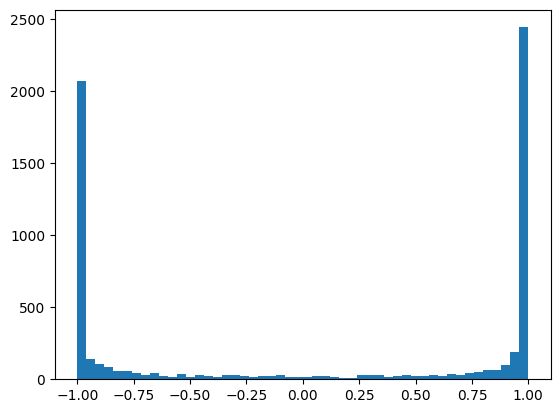

In [73]:
plt.hist(h.view(-1).tolist(), bins = 50)

In [75]:
h.shape

torch.Size([32, 200])

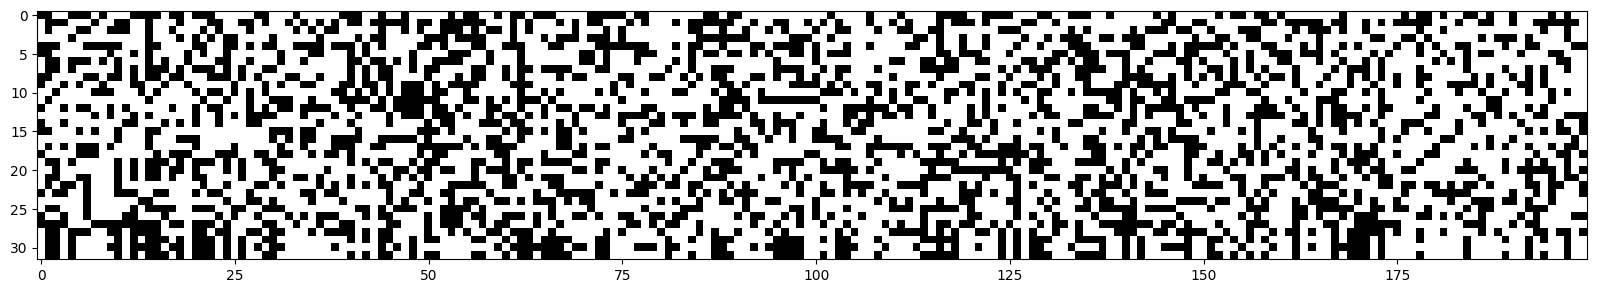

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# h.abs() > 0.99 is boolean tensor
# shows 'white is true, black is false'
# image shows h, which has 32 examples and 200 hidden neurons.

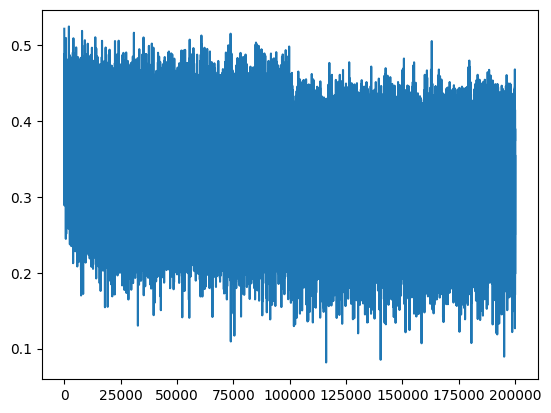

In [56]:
plt.plot(lossi)

In [57]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


In [12]:
# emd lookup table인 이유
C[5] == F.one_hot(torch.tensor(5), num_classes=vocab_size).float() @ C

C.shape # torch.Size([27, 10])

C[[5,6,7]]

tensor([[-0.9076,  0.4514, -0.0896, -0.9439,  0.2727,  0.4211,  0.4537, -0.3583,
         -0.6286,  0.0757],
        [ 0.8852, -0.5475, -1.7188, -1.4424,  0.7666, -0.3779,  1.5484,  2.7362,
         -0.9158,  0.4861],
        [-0.3037,  0.5863, -0.3471,  0.2158,  0.2101,  0.4904,  0.5042,  0.2936,
         -0.5448,  0.2392]], grad_fn=<IndexBackward0>)

In [13]:
C[5]

tensor([-0.9076,  0.4514, -0.0896, -0.9439,  0.2727,  0.4211,  0.4537, -0.3583,
        -0.6286,  0.0757], grad_fn=<SelectBackward0>)

In [14]:
C[6]

tensor([ 0.8852, -0.5475, -1.7188, -1.4424,  0.7666, -0.3779,  1.5484,  2.7362,
        -0.9158,  0.4861], grad_fn=<SelectBackward0>)

In [15]:
C[7]

tensor([-0.3037,  0.5863, -0.3471,  0.2158,  0.2101,  0.4904,  0.5042,  0.2936,
        -0.5448,  0.2392], grad_fn=<SelectBackward0>)

아래 코드는,
1. 모델이 예측한 확률 분포(Probability Distribution)을 얻어내고,
2. 그 분포로부터 가장 가능성 높은 것을 확률에 따라 뽑기(Sampling)하고,
3. 뽑힌 결과를 다음 예측의 입력으로 다시 사용하여, 한 글자씩 단어를 '조립'하는 과정과 같다. 

In [16]:
# sample from the model
g = torch.Generator().manual_seed(seed_num + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)  # probabilities of next character 
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nah.
yal.
renyra.
endrael.
adeeroselin.
shy.
jenne.
elisson.
artelyn.
malkia.
noshubergahimies.
kendreelle.
jose.
casu.
zen.
der.
yarleyeks.


In [17]:
probs.shape

torch.Size([1, 27])